# Analysis

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns


In [2]:
arb_df = pd.read_csv('../arb-contracts-final-results.csv')
eth_df = pd.read_csv('../eth-contracts-final-results.csv')
ftm_df = pd.read_csv('../ftm-contracts-final-results.csv')
opt_df = pd.read_csv('../opt-contracts-final-results.csv')
pol_df = pd.read_csv('../pol-contracts-final-results.csv')

# add column to each df to indicate the blockchain
arb_df['Blockchain'] = 'arb'
eth_df['Blockchain'] = 'eth'
ftm_df['Blockchain'] = 'ftm'
opt_df['Blockchain'] = 'opt'
pol_df['Blockchain'] = 'pol'

combined_df = pd.concat([arb_df, eth_df, ftm_df, opt_df, pol_df])


In [3]:
def create_sub_df(df, keyword):
    new_df = df.filter(regex=f'^({keyword}|Blockchain)')
    new_df.columns = new_df.columns.str.replace(keyword, '')
    return new_df

combined_metrics_df = create_sub_df(combined_df, 'metrics.')
combined_patterns_df = create_sub_df(combined_df, 'patterns.')


In [4]:
combined_patterns_df = combined_patterns_df.rename(index={'Storage Optimization': 'Storage Saver'})

In [5]:
def get_stats(df):
    df_stats = df.describe()
    df_stats.loc['mode'] = df.mode().iloc[0]
    df_stats = df_stats.rename(index={'50%': 'median'})
    df_stats = df_stats.drop('count')
    return df_stats

combined_stats = get_stats(combined_metrics_df)


## Metric Boxplots

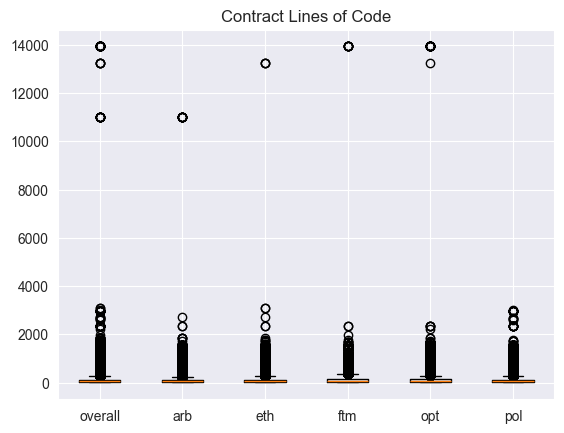

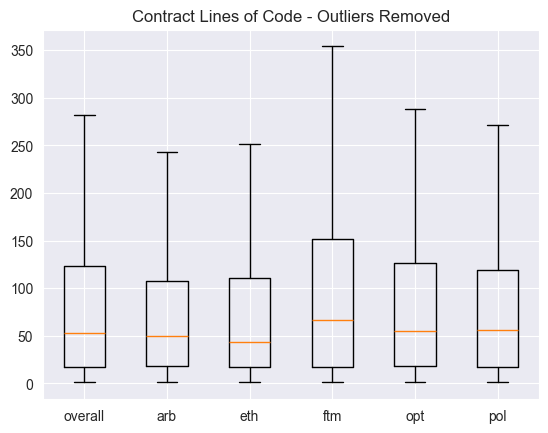

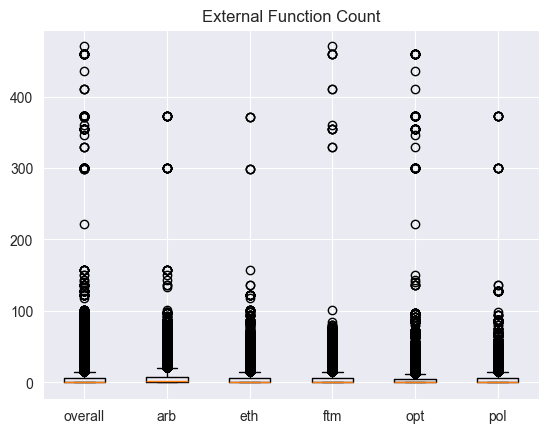

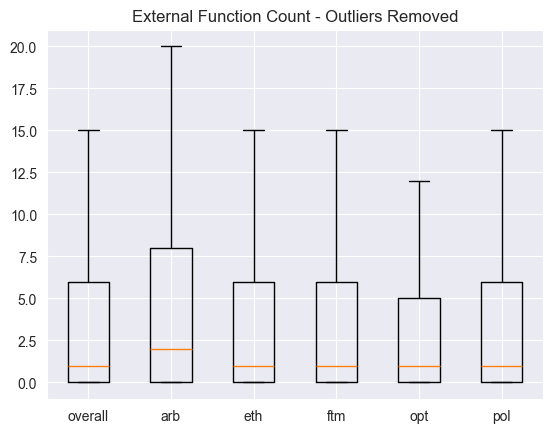

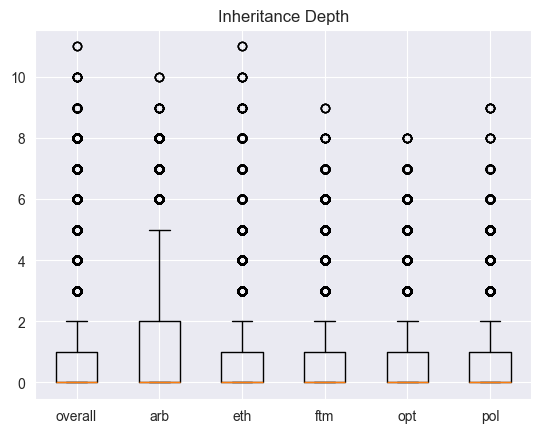

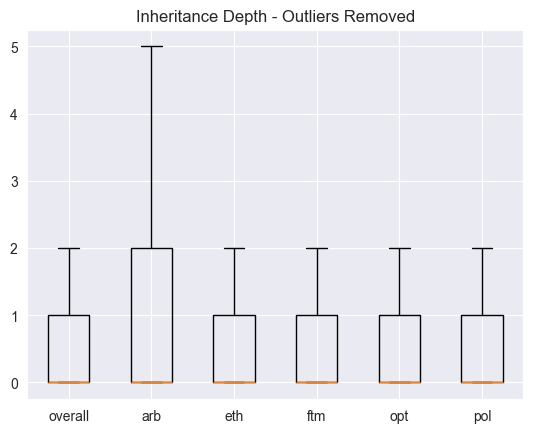

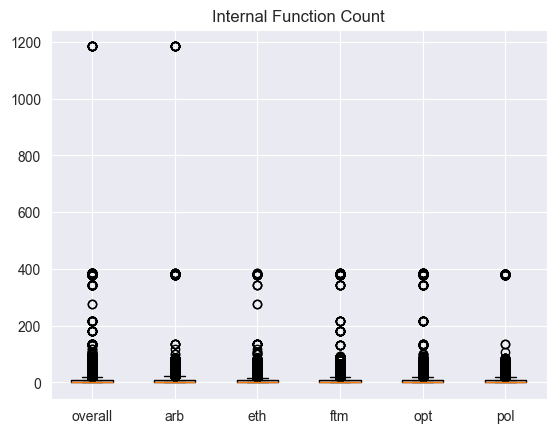

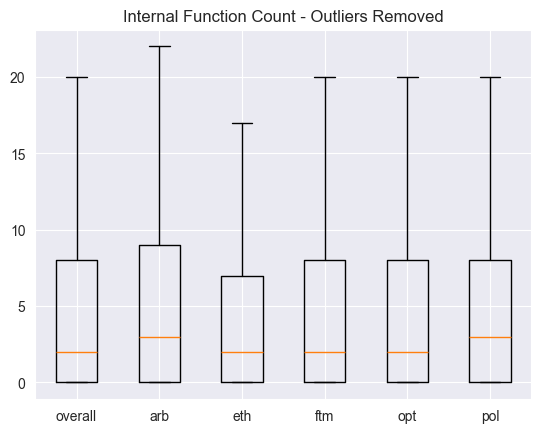

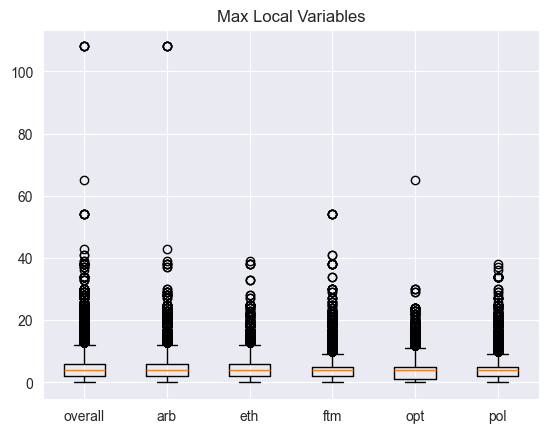

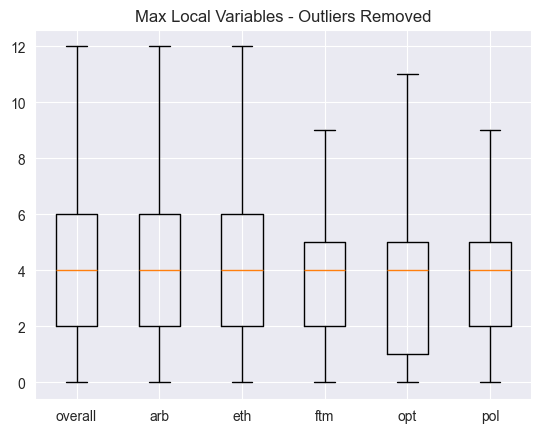

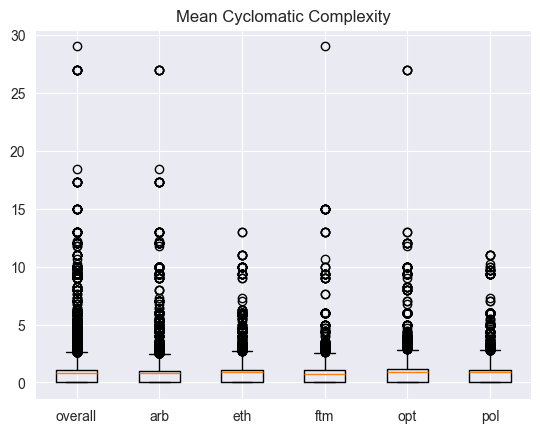

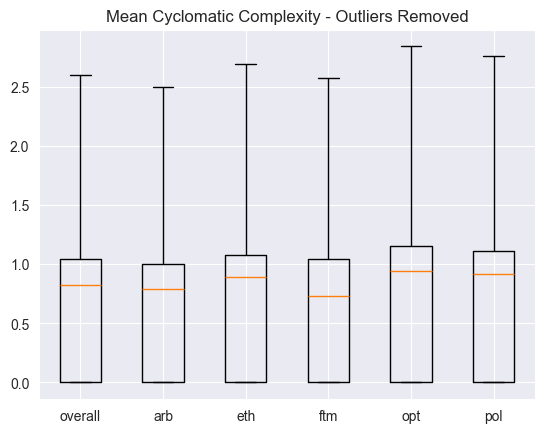

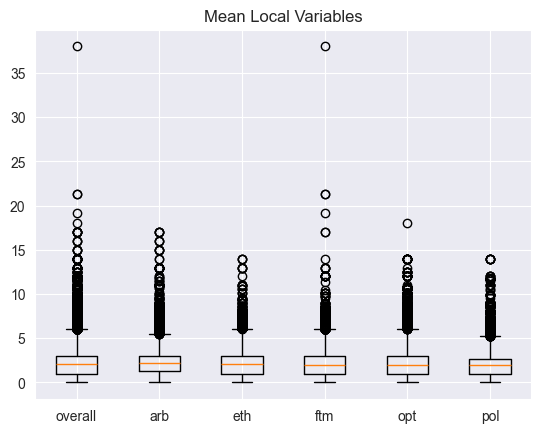

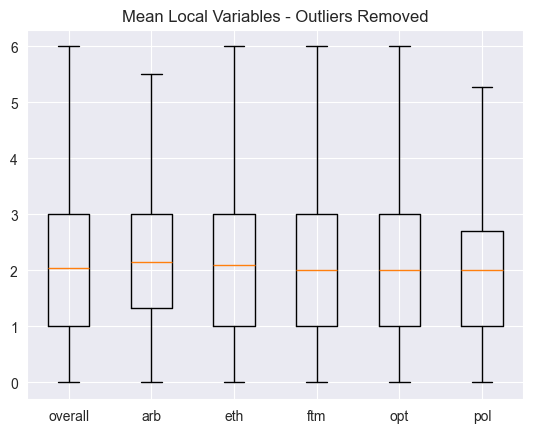

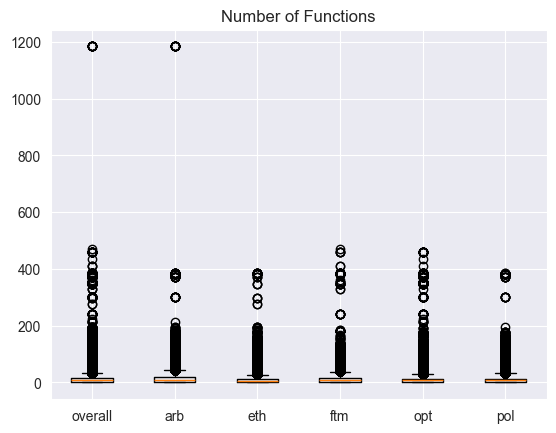

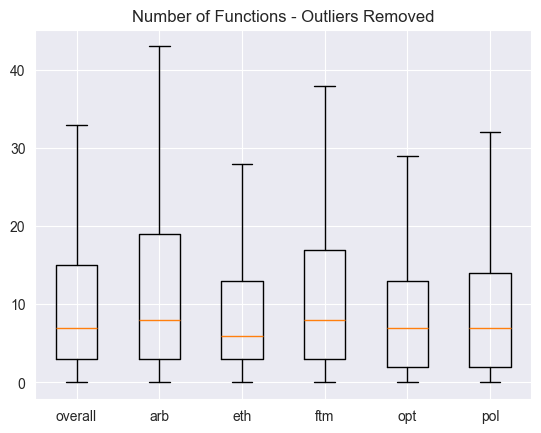

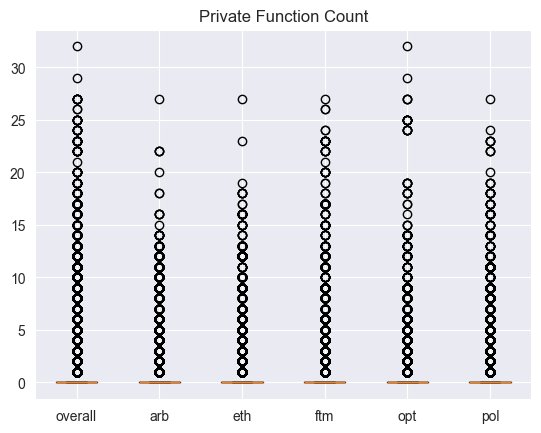

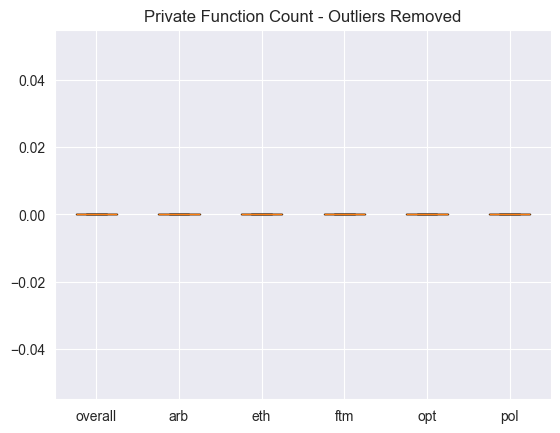

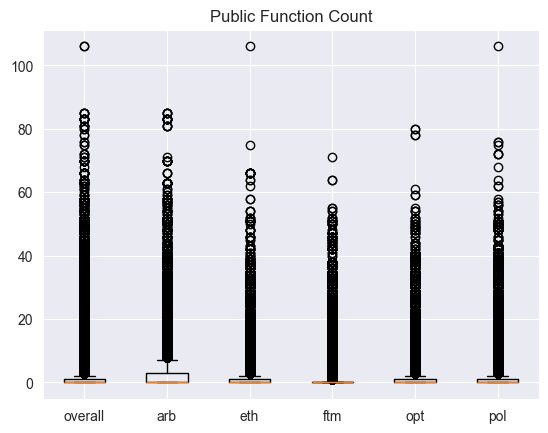

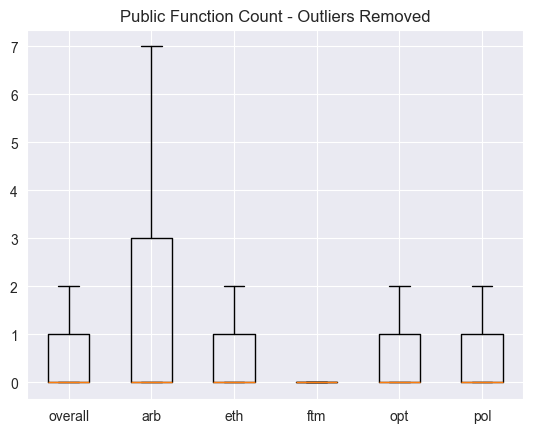

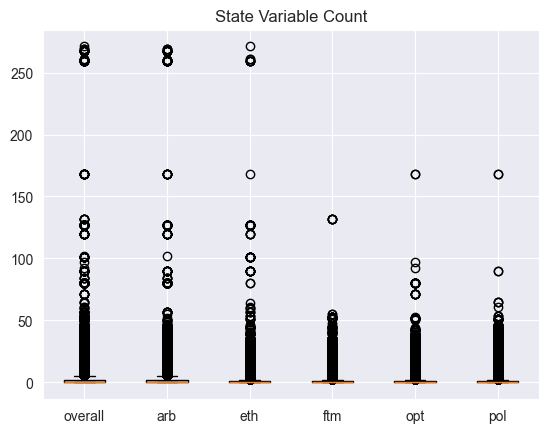

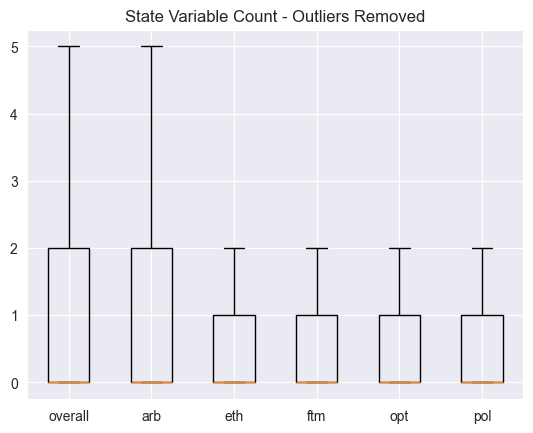

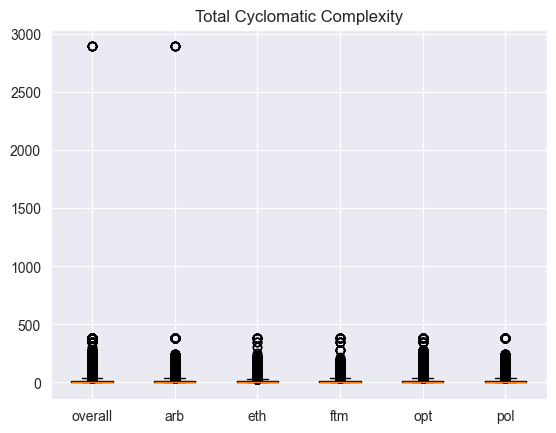

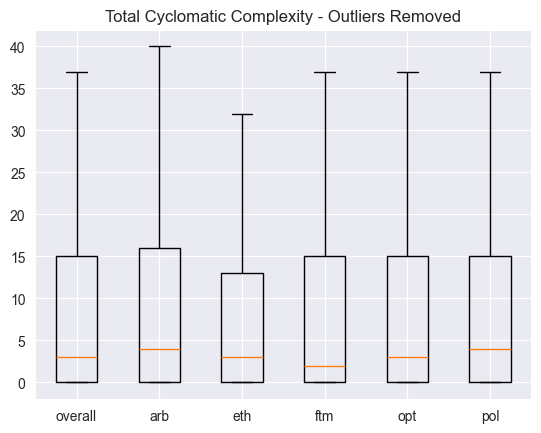

In [6]:
def create_boxplot(df, column, title, show_outliers=True):
    fig = plt.figure()
    plt.title(title)

    data = [df[column]]
    labels = ['overall']
    for name, group in df.groupby('Blockchain'):
        data.append(group[column])
        labels.append(name)
    plt.boxplot(data, tick_labels=labels, showfliers=show_outliers)
    plt.show()

for metric in combined_stats.columns:
    create_boxplot(combined_metrics_df, metric, metric)
    create_boxplot(combined_metrics_df, metric, metric + ' - Outliers Removed', False)

## Average Metrics

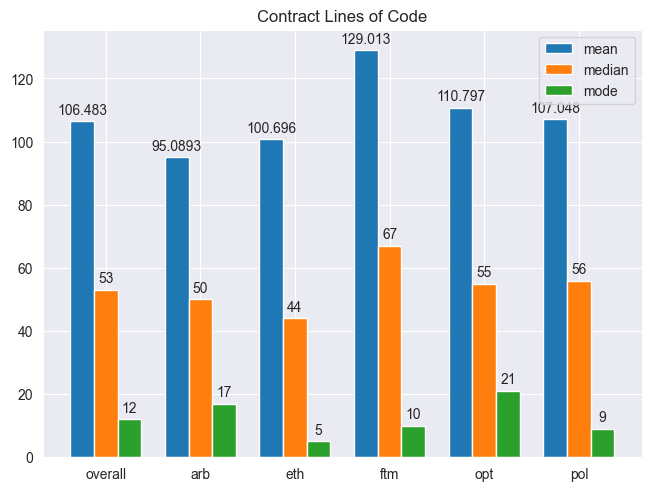

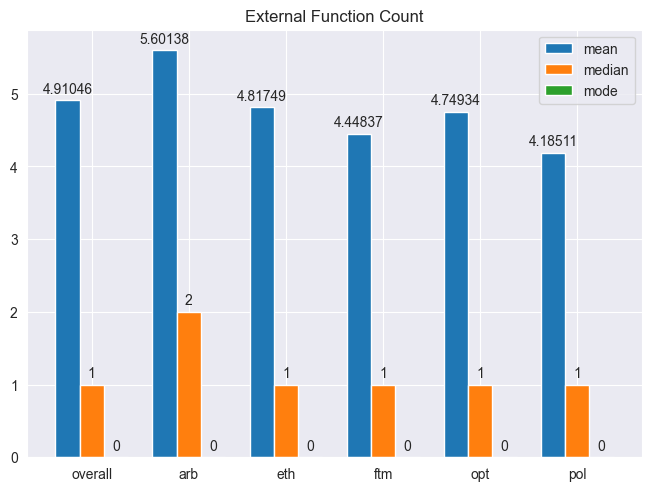

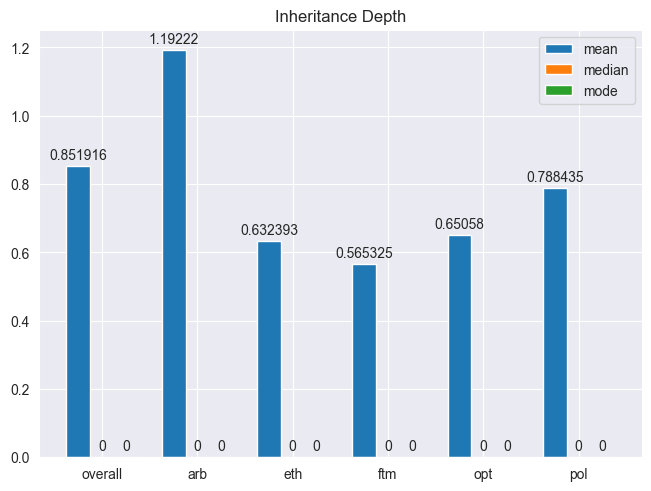

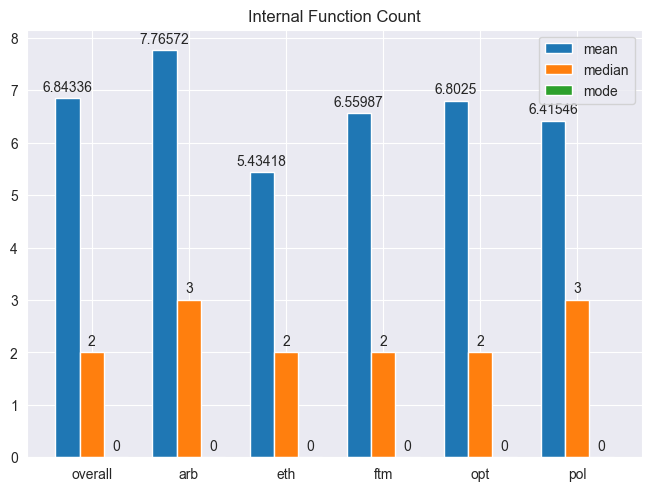

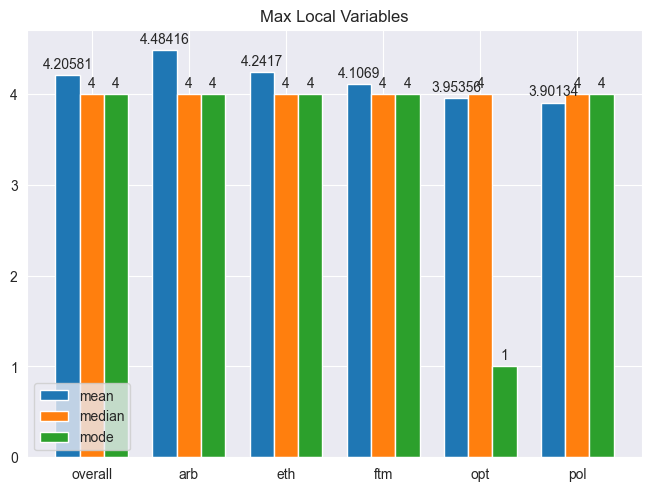

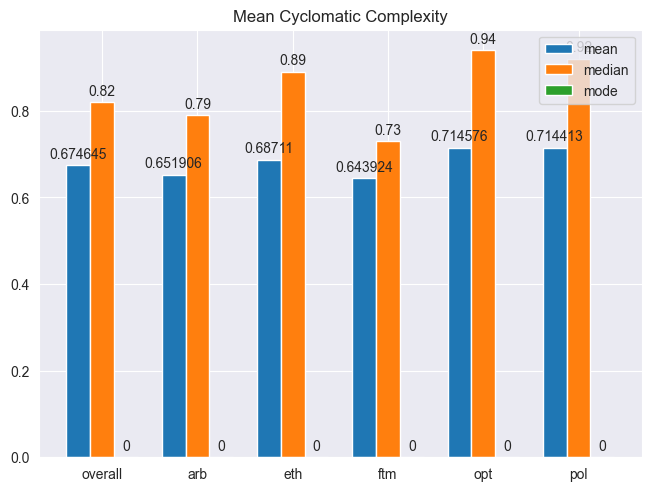

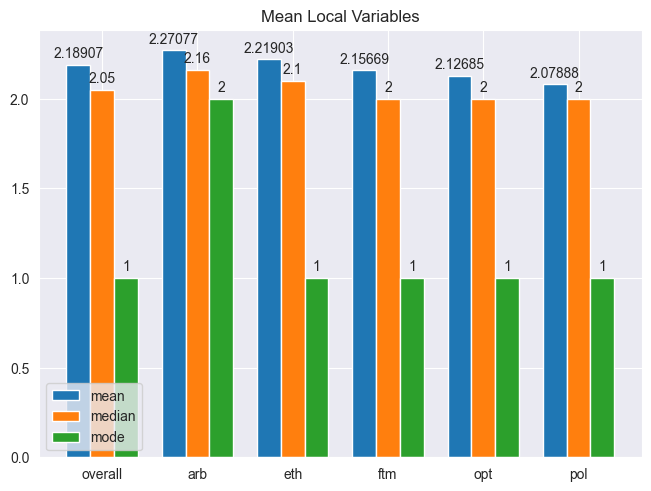

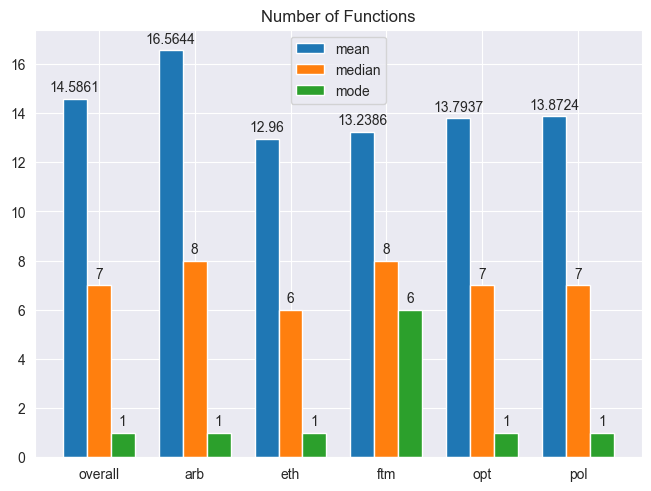

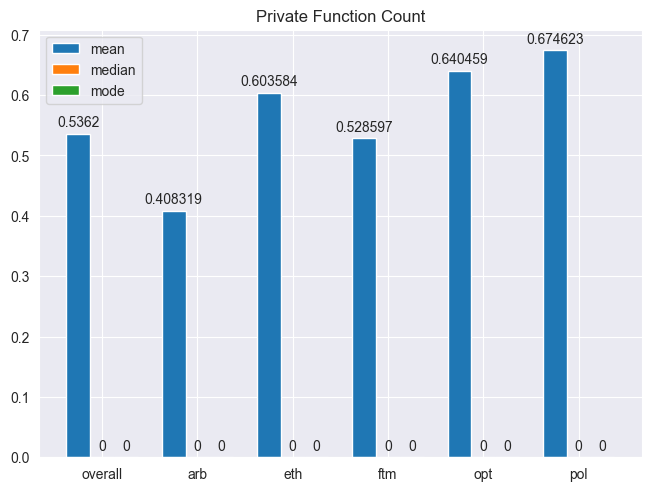

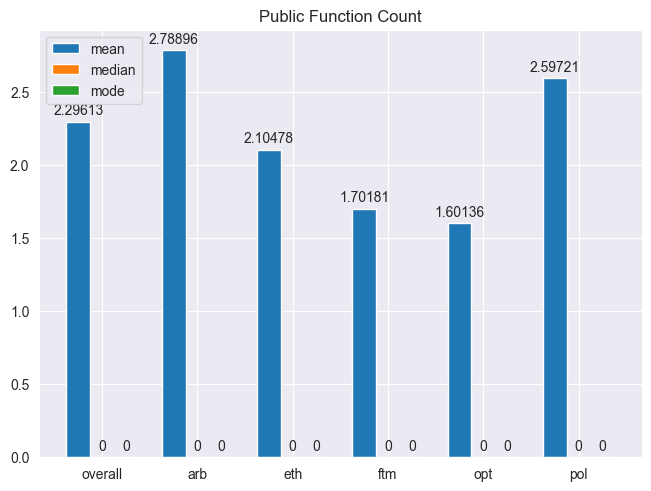

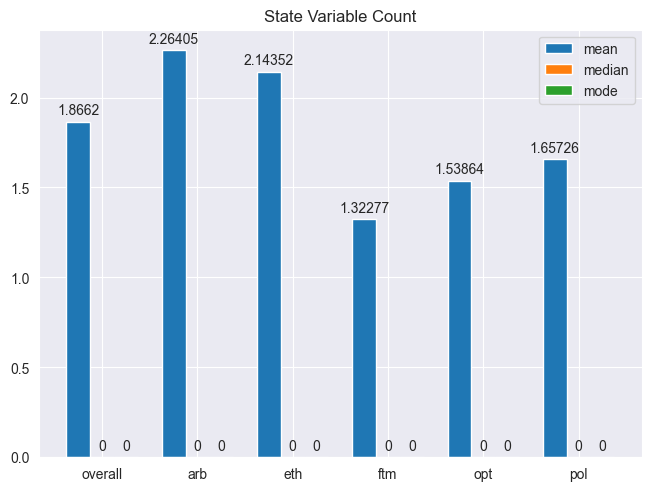

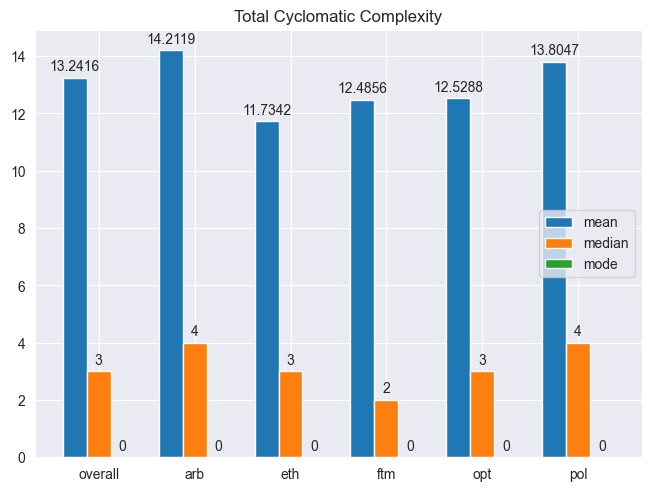

In [7]:
def plot_averages(df, metric, title):
    means = [df[metric].mean()]
    medians = [df[metric].median()]
    modes = [df[metric].mode().iloc[0]]
    labels = ['overall']

    for name, group in df.groupby('Blockchain'):
        means.append(group[metric].mean())
        medians.append(group[metric].median())
        modes.append(group[metric].mode().iloc[0])
        labels.append(name)

    data = {
        'mean': means,
        'median': medians,
        'mode': modes
    }

    label_loc = np.arange(len(labels))
    width = 0.25  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    for key, value in data.items():
        offset = width * multiplier
        rects = ax.bar(label_loc + offset, value, width, label=key)
        ax.bar_label(rects, padding=3)
        multiplier += 1

    ax.set_xticks(label_loc + width, labels)

    plt.title(title)
    plt.legend()
    plt.show()

for metric in combined_stats.columns:
    plot_averages(combined_metrics_df, metric, metric)


## Correlation Analysis

In [10]:
metrics = combined_metrics_df.columns.drop('Blockchain')
patterns = combined_patterns_df.columns.drop('Blockchain')
# drop patterns removed from the final analysis
patterns = patterns.drop('Multi Return')
patterns = patterns.drop('State Machine')
patterns = patterns.drop('Permissioned')
patterns = patterns.drop('Permissionless')

### Point-Biserial Correlation

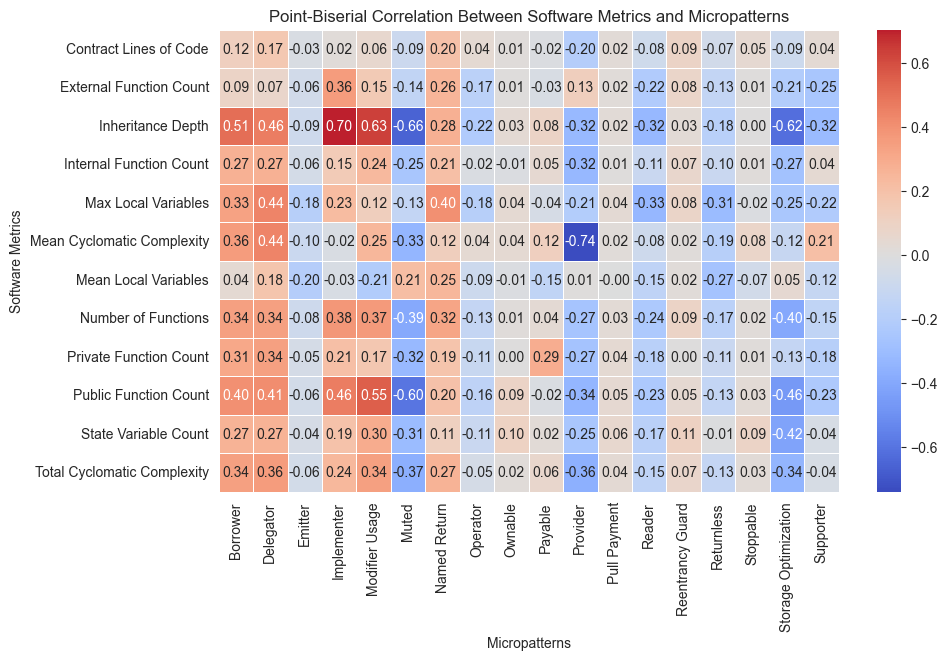

In [16]:
def point_biserial_corr():
    corr_matrix = pd.DataFrame(index=metrics, columns=patterns)

    for pattern in patterns:
        for metric in metrics:
            r, p = stats.pointbiserialr(combined_metrics_df[metric], combined_patterns_df[pattern])
            corr_matrix.loc[metric, pattern] = r

    corr_matrix = corr_matrix.astype(float)

    # Plot correlation matrix as a heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5)

    # Labels and title
    plt.title("Point-Biserial Correlation Between Software Metrics and Micropatterns")
    plt.xlabel("Micropatterns")
    plt.ylabel("Software Metrics")

    # Show the plot
    plt.show()

point_biserial_corr()

### ANOVA/Kruskal-Wallis Test

In [18]:
def is_normal(data):
    _, p = stats.normaltest(data, nan_policy='omit')
    return p > 0.05  # p > 0.05 means data is approximately normal

def anova_kruskal_wallis():
    for metric in metrics:
        groups = [group[metric] for name, group in combined_metrics_df.groupby('Blockchain')]
        if all(is_normal(g) for g in groups):  # Check normality
            f_stat, p_val = stats.f_oneway(*groups)
            print(f"{metric}: ANOVA F = {f_stat:.4f}, p = {p_val:.4e} (Assumes normality)")
        else:
            h_stat, p_val = stats.kruskal(*groups)
            print(f"{metric}: Kruskal-Wallis H = {h_stat:.4f}, p = {p_val:.4e} (Non-parametric)")

anova_kruskal_wallis()

Contract Lines of Code: Kruskal-Wallis H = 1517.2963, p = 0.0000e+00 (Non-parametric)
External Function Count: Kruskal-Wallis H = 4188.7767, p = 0.0000e+00 (Non-parametric)
Inheritance Depth: Kruskal-Wallis H = 8233.3914, p = 0.0000e+00 (Non-parametric)
Internal Function Count: Kruskal-Wallis H = 1011.3768, p = 1.2219e-217 (Non-parametric)
Max Local Variables: Kruskal-Wallis H = 4437.8900, p = 0.0000e+00 (Non-parametric)
Mean Cyclomatic Complexity: Kruskal-Wallis H = 1273.7584, p = 1.6278e-274 (Non-parametric)
Mean Local Variables: Kruskal-Wallis H = 1716.9893, p = 0.0000e+00 (Non-parametric)
Number of Functions: Kruskal-Wallis H = 1608.5548, p = 0.0000e+00 (Non-parametric)
Private Function Count: Kruskal-Wallis H = 2900.8804, p = 0.0000e+00 (Non-parametric)
Public Function Count: Kruskal-Wallis H = 3703.1547, p = 0.0000e+00 (Non-parametric)
State Variable Count: Kruskal-Wallis H = 3534.3963, p = 0.0000e+00 (Non-parametric)
Total Cyclomatic Complexity: Kruskal-Wallis H = 710.1688, p = 

**CHATGPT RESULTS ANALYSIS**

These results are from the Kruskal-Wallis H test, a non-parametric alternative to ANOVA. They indicate whether the distribution of a given software metric varies significantly across different blockchain platforms.

Interpreting the Results
Each row corresponds to a software metric tested across different blockchains.

H-statistic (H-value): Measures the degree of difference among blockchain groups. Higher values indicate stronger differences.
p-value: Determines statistical significance.
If p < 0.05, the differences across blockchains are statistically significant.
If p ≈ 0, the differences are highly significant (as seen in your results).
Since all p-values are effectively 0, we can strongly reject the null hypothesis, meaning:

At least one blockchain platform exhibits significantly different software metric distributions compared to the others.

Key Observations
All metrics show significant differences across blockchains

Since all p-values are extremely small (many < 1e-200), it means blockchain platform choice significantly impacts smart contract software metrics.
Metrics with the highest H-values show the most variation

Inheritance Depth (H = 8233.39) varies the most between blockchains.
External Function Count (H = 4188.77) and Max Local Variables (H = 4437.89) also exhibit strong blockchain-based variation.
Total Cyclomatic Complexity (H = 710.16) shows the least variation but is still significant.
What This Means for Your Research
Since blockchain platforms significantly impact software metrics, you should:

Investigate how architectural differences cause these variations.

Does Ethereum encourage deeper inheritance hierarchies more than Binance Smart Chain?
Are smart contracts more function-heavy on certain blockchains?
Are some blockchains more complex due to execution costs or gas optimizations?
Perform post-hoc tests to identify which blockchains differ the most.

Pairwise Mann-Whitney U-tests can show which blockchain pairs differ significantly.
Dunn’s post-hoc test (with Bonferroni correction) can refine results.
Consider visualizing these differences using boxplots or violin plots.

This will highlight distribution variations across blockchains.
Would you like help running post-hoc tests or visualizing these results? 🚀

### Partial Correlation (Controlling for Blockchain)

In [ ]:
def partial_corr():
    for metric in metrics:
        result = pg.partial_corr(data=df, x=metric, y='micropattern_present', covar='blockchain', method='pearson')
        print(f"{metric}: r = {result['r'].values[0]:.4f}, p = {result['p-val'].values[0]:.4e}")
